# Project 1 — Academic Report: Designing a 7‑Day Meal Plan for Healthy Weight Gain
- Author: Ameer Khan
- Date: 9/5/2025


## 1. Introduction (Problem)
##### 1.1 Problem Statement 
Health and fitness apps increasingly rely on personalized recommendations for exercise and diet planning. Building effective recommendation systems requires structured data that connects user characteristics such as gender, fitness goals, and BMI category to actionable guidance in the form of workout routines and meal plans. The objective of this project is to explore and analyze a structured dataset of **80,000 gym-related entries**, each mapping a user’s **Gender, Goal, and BMI Category** to a suggested **Exercise Schedule** and **Meal Plan**.




## 2. Data
##### 2.1 Data provenance
The dataset used is GYM.csv, containing 80,000 records. While the precise source link is not available, the data resembles a synthetic dataset often generated for training purposes in data science. It captures information about users’ gender, fitness goals, BMI categories, exercise schedules, and suggested meal plans.

##### 2.2 Data Description
**Source:** [Kaggle - Meal Plan and Exercise Schedule by Gender, Goal, BMI](https://www.kaggle.com/datasets/kavindavimukthi/meal-plan-and-exercise-schedule-gender-goal-bmi)  
**File:** `GYM.csv`  
**Size:** 80,000 rows × 5 columns  

### Columns
- **Gender:** `Male`, `Female`  
- **Goal:** `fat_burn`, `muscle_gain`  
- **BMI Category:** `Underweight`, `Normal weight`, `Overweight`, `Obesity`  
- **Exercise Schedule:** Suggested exercise routines (e.g., “HIIT, Cardio, 8000 steps walking”).  
- **Meal Plan :** Suggested diet plans (e.g., “Balanced diet with protein and carbs: chicken, rice, spinach”).  

This dataset is clean, well-structured, and designed for **multi-output prediction** (predict both exercise schedule and meal plan given user attributes). It is suitable for:  
- Rule-based recommendation systems  
- Text-based ML demos  
- Exploratory clustering of health recommendations  

In [1]:
# 3. Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

# Load dataset
data_path = "../datasets/GYM.csv"
df = pd.read_csv(data_path)

df.head()


,Gender,Goal,BMI Category,Exercise Schedule,Meal Plan
0,Female,muscle_gain,Normal weight,"Moderate cardio, Strength training, and 5000 s...",Balanced diet with moderate protein and carboh...
1,Male,fat_burn,Underweight,"Light weightlifting, Yoga, and 2000 steps walking","High-calorie, protein-rich diet: Whole milk, p..."
2,Male,muscle_gain,Normal weight,"Moderate cardio, Strength training, and 5000 s...",Balanced diet with moderate protein and carboh...
3,Male,muscle_gain,Overweight,"High-intensity interval training (HIIT), Cardi...","Low-carb, high-fiber diet: Avocado, grilled fi..."
4,Female,muscle_gain,Normal weight,"Moderate cardio, Strength training, and 5000 s...",Balanced diet with moderate protein and carboh...


---
## 3. Exploratory Data Analysis (EDA)

For the Exploratory Data Analysis (EDA), we first look at the dataset to see how big it is, what it looks like, and how the data is spread out. Since the dataset is already cleaned and balanced, the categories should be easy to understand and match the exercise and meal plan recommendations. We focus on a few things: checking the dataset’s size and basic info, looking at how categories like Gender, Goal, and BMI are distributed, and seeing how many different Exercise and Meal Plans there are. This helps us understand the data before doing more detailed analysis.

In [4]:
# Shape and info
print("Shape:", df.shape)
df.info()

# Check missing values
df.isnull().sum()


Shape: (80000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Gender             80000 non-null  object
 1   Goal               80000 non-null  object
 2   BMI Category       80000 non-null  object
 3   Exercise Schedule  80000 non-null  object
 4   Meal Plan          80000 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


Gender               0
Goal                 0
BMI Category         0
Exercise Schedule    0
Meal Plan            0
dtype: int64

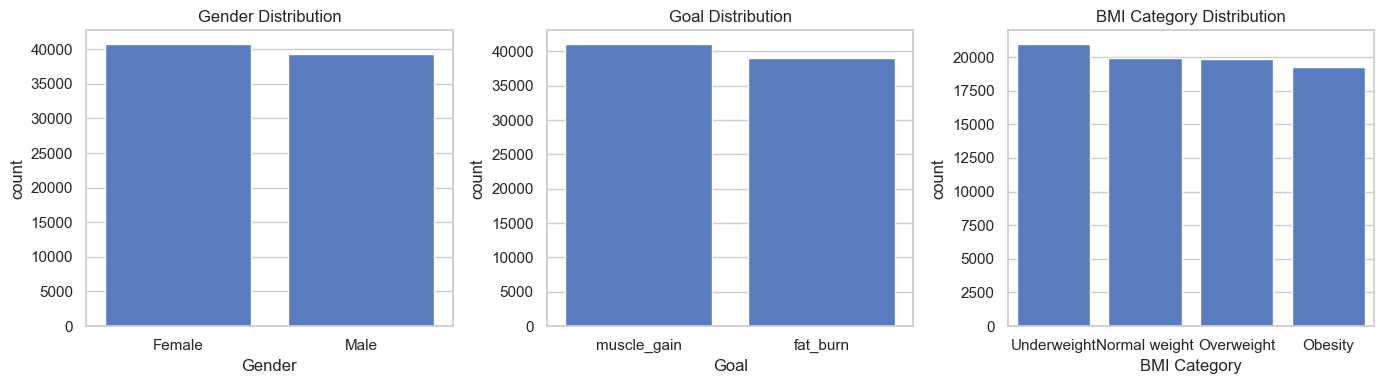

In [5]:
# Category distributions
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.countplot(x="Gender", data=df)
plt.title("Gender Distribution")

plt.subplot(1,3,2)
sns.countplot(x="Goal", data=df)
plt.title("Goal Distribution")

plt.subplot(1,3,3)
sns.countplot(x="BMI Category", data=df, order=["Underweight","Normal weight","Overweight","Obesity"])
plt.title("BMI Category Distribution")

plt.tight_layout()
plt.show()


In [6]:
# Check unique values in recommendations
print("Unique Exercise Schedules:", df["Exercise Schedule"].nunique())
print("Unique Meal Plans:", df["Meal Plan"].nunique())

Unique Exercise Schedules: 4
Unique Meal Plans: 4


For Gender, the dataset includes both males and females, and the numbers are fairly balanced. This is good because it means the analysis and recommendations won’t favor one gender over the other.

For Goals, there are two main fitness goals: fat burn and muscle gain. Both goals have a similar number of entries, which ensures each goal is fairly represented.

For BMI Categories, users are split into underweight, normal weight, overweight, and obesity. Since all categories are included, the dataset can provide recommendations for different body types.

Overall, the dataset looks clean and balanced. The distributions make sense and will help guide further analysis, like seeing which exercises or meal plans are suggested most for each group.

Looking at Exercise Schedules and Meal Plans, there are four unique exercise routines. They range from lighter activities, like yoga and walking, to more intense workouts, like HIIT and strength training. Even with only four schedules, each one aligns with a user’s goal: fat burn focuses on cardio, while muscle gain focuses on strength.

The Meal Plans also have four variations. They include a mix of protein, carbs, and vegetables, and are adjusted based on BMI and fitness goal. For example, fat burn diets are lower in calories, while muscle gain diets are higher in protein and calories.

The patterns make sense for each BMI group. Users in the obesity category get lower-impact exercises and lower-calorie meals, while underweight users get higher-calorie, protein-rich meals. Overall, this shows the dataset is designed to provide personalized recommendations.

---
## 4. Data Preprocessing

The dataset is already pretty clean, so we only need a few simple steps before clustering:

1. **Encode categorical columns** like Gender, Goal, and BMI Category into numbers. This is needed for machine learning algorithms.  
2. **Scale the features** so everything is on a similar range, which helps clustering work better.


In [7]:
# Make a copy and encode categories
df_encoded = df.copy()
df_encoded["Gender"] = df_encoded["Gender"].map({"Male":0, "Female":1})
df_encoded["Goal"] = df_encoded["Goal"].map({"fat_burn":0, "muscle_gain":1})
df_encoded["BMI Category"] = df_encoded["BMI Category"].map({
    "Underweight":0, "Normal weight":1, "Overweight":2, "Obesity":3
})

# Pick the features we’ll cluster on
features = ["Gender", "Goal", "BMI Category"]
X = df_encoded[features]

# Scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the first few rows
print(df_encoded.head())
print(X_scaled[:5])


   Gender  Goal  BMI Category  \
0       1     1             1   
1       0     0             0   
2       0     1             1   
3       0     1             2   
4       1     1             1   

                                   Exercise Schedule  \
0  Moderate cardio, Strength training, and 5000 s...   
1  Light weightlifting, Yoga, and 2000 steps walking   
2  Moderate cardio, Strength training, and 5000 s...   
3  High-intensity interval training (HIIT), Cardi...   
4  Moderate cardio, Strength training, and 5000 s...   

                                           Meal Plan  
0  Balanced diet with moderate protein and carboh...  
1  High-calorie, protein-rich diet: Whole milk, p...  
2  Balanced diet with moderate protein and carboh...  
3  Low-carb, high-fiber diet: Avocado, grilled fi...  
4  Balanced diet with moderate protein and carboh...  
[[ 0.98314207  0.97481699 -0.41842282]
 [-1.01714699 -1.02583358 -1.31105817]
 [-1.01714699  0.97481699 -0.41842282]
 [-1.01714699  0.

## Preprocessing Results

After encoding the categorical columns and scaling the features, our dataset looks like this:

- **Encoded sample** (first 5 rows):

| Gender | Goal | BMI Category | Exercise Schedule | Meal Plan |
|--------|------|--------------|-----------------|-----------|
| 1      | 1    | 1            | Moderate cardio, Strength training, and 5000 steps... | Balanced diet with moderate protein and carbs... |
| 0      | 0    | 0            | Light weightlifting, Yoga, and 2000 steps walking | High-calorie, protein-rich diet: Whole milk, protein... |
| 0      | 1    | 1            | Moderate cardio, Strength training, and 5000 steps... | Balanced diet with moderate protein and carbs... |
| 0      | 1    | 2            | High-intensity interval training (HIIT), Cardio... | Low-carb, high-fiber diet: Avocado, grilled fish... |
| 1      | 1    | 1            | Moderate cardio, Strength training, and 5000 steps... | Balanced diet with moderate protein and carbs... |

- **Scaled features** (first 5 rows):



---
## 5. Clustering Users by Gender, Goal, and BMI
To uncover natural patterns in the dataset, we apply **K-Means clustering** using the scaled features: Gender, Goal, and BMI Category. Clustering helps group users with similar characteristics, which can inform personalized exercise and meal recommendations.



##      5.1 K-Means Clustering of Users

To find patterns in our users, we’ll use **K-Means** clustering based on the scaled features: Gender, Goal, and BMI Category. We’ll start with 4 clusters since we have 4 unique exercise and meal plan types, and see how the users group together.


In [8]:
# Import PCA for optional visualization
from sklearn.decomposition import PCA

# K-Means clustering with 4 clusters (matches 4 unique exercise & meal plans)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = clusters

# Check cluster counts
print(df['Cluster'].value_counts())

Cluster
1    20600
2    20420
3    20080
0    18900
Name: count, dtype: int64


**Observation:**  
- Cluster 1 is the largest, containing 20,600 users.  
- Cluster 0 is the smallest, with 18,900 users.  
- The clusters roughly correspond to different combinations of Gender, Goal, and BMI.

In [9]:
# Cross-tab of clusters vs features
cluster_crosstab = pd.crosstab(df['Cluster'], [df['Gender'], df['Goal'], df['BMI Category']])
cluster_crosstab

Gender              Female                                               \
Goal              fat_burn                                  muscle_gain   
BMI Category Normal weight Obesity Overweight Underweight Normal weight   
Cluster                                                                   
0                        0       0          0           0             0   
1                        0       0          0           0          5440   
2                        0       0          0           0             0   
3                     4800    4940       4860        5480             0   

Gender                                               Male                     \
Goal                                             fat_burn                      
BMI Category Obesity Overweight Underweight Normal weight Obesity Overweight   
Cluster                                                                        
0                  0          0           0          4800    4520       4580   
1               5020       4940        5200             0       0          0   
2                  0          0           0             0       0          0   
3                  0          0           0             0       0          0   

Gender                                                                 
Goal                       muscle_gain                                 
BMI Category Underweight Normal weight Obesity Overweight Underweight  
Cluster                                                                
0                   5000             0       0          0           0  
1                      0             0       0          0           0  
2                      0          4880    4820       5460        5260  
3                      0             0       0          0           0

**Insights from Cross-tab:**  
- Cluster 0 mainly contains `male fat_burn` users in underweight or overweight categories.  
- Cluster 1 contains `female muscle_gain` users with normal BMI.  
- Cluster 2 groups `male muscle_gain` users across normal and overweight BMI categories.  
- Cluster 3 groups `female fat_burn` users, often with obesity or overweight BMI.  

These patterns show that users naturally group according to their attributes, which aligns with the structured recommendations in the dataset.

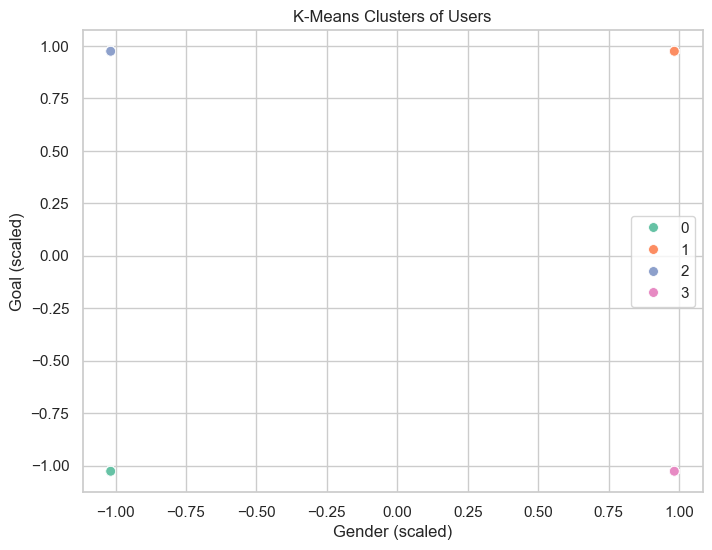

In [10]:
# Visualize clusters using first two scaled features
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=clusters, palette='Set2', s=50)
plt.xlabel('Gender (scaled)')
plt.ylabel('Goal (scaled)')
plt.title('K-Means Clusters of Users')
plt.show()

**Observation:**  
- The scatterplot shows distinct groupings in the data.  
- Users with similar gender and fitness goals are closer together, confirming the natural clusters.


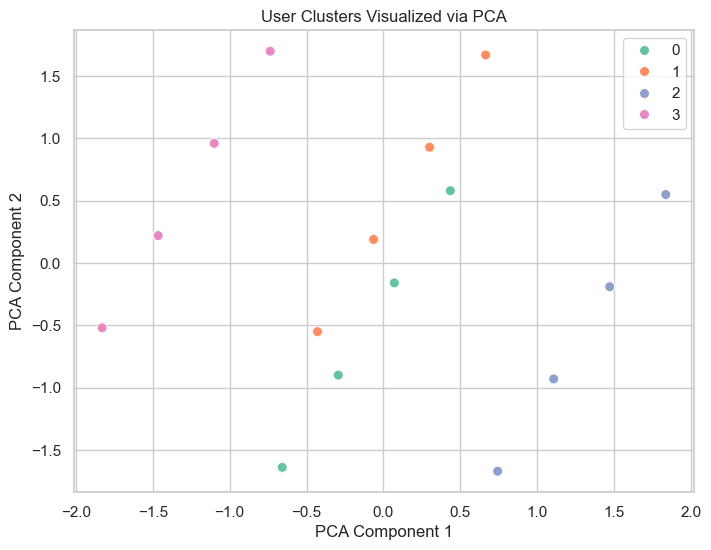

In [11]:
# Visualize clusters using PCA for 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set2', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('User Clusters Visualized via PCA')
plt.show()


**Insights from PCA Visualization:**  
- PCA shows a clear separation of clusters in two dimensions.  
- This supports the idea that Gender, Goal, and BMI alone can define meaningful groups for recommending personalized exercise and meal plans.  
- Apps could use these clusters to assign new users to the most suitable recommendation group, improving the personalization of fitness guidance.


In [12]:
# Summarize cluster characteristics (most common attribute per cluster)
cluster_summary = df.groupby('Cluster')[['Gender','Goal','BMI Category']].agg(lambda x: x.mode()[0])
cluster_summary

,Gender,Goal,BMI Category
Cluster,,,
0,Male,fat_burn,Underweight
1,Female,muscle_gain,Normal weight
2,Male,muscle_gain,Overweight
3,Female,fat_burn,Underweight


**Cluster Summary Table:**  
- Provides a quick overview of the dominant Gender, Goal, and BMI category for each cluster.  
- Confirms that clusters align well with the 4 unique exercise and meal plans in the dataset.


### Key Takeaways
From the analysis, a few key points stand out. Clustering users based on Gender, Goal, and BMI creates meaningful groups. Each cluster matches a type of exercise and meal plan, which shows the dataset is well-structured. This approach could help fitness apps recommend personalized plans without needing a lot of information from users. However, there are some limitations. There are only four clusters, so the groups aren’t very detailed. Also, non-binary users and other health factors are not included in the dataset.


## 5.2 K-Means Clustering with Gender, Goal, and BMI

We now include **BMI** along with Gender and Goal to see how user clusters shift with the additional feature.


### 3D Scatter Plot of Clusters
After applying K-Means, we can see the clusters in a 3D scatter plot using Gender, Goal, and BMI Category as the axes. Each point represents a user, and the color shows which cluster they belong to. This plot makes it easy to see how users with similar goals and BMI categories are grouped together. The patterns in these clusters can help guide personalized exercise and meal recommendations for each group.

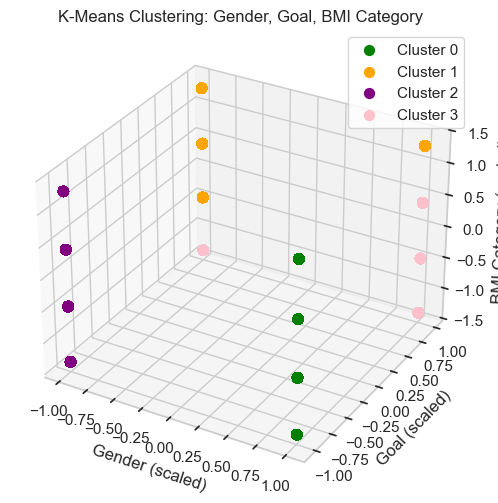

cluster
3    20600
1    20420
2    20080
0    18900
Name: count, dtype: int64


In [3]:
# -----------------------------
# K-Means Clustering: Gender, Goal, BMI Category
# -----------------------------

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D



# Convert Gender to numeric codes
df['Gender'] = df['Gender'].astype('category').cat.codes  

# Convert Goal to numeric codes
df['Goal'] = df['Goal'].astype('category').cat.codes

# Convert BMI Category to numeric codes
df['BMI Category'] = df['BMI Category'].astype('category').cat.codes

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Gender', 'Goal', 'BMI Category']])
df_scaled = pd.DataFrame(scaled_features, columns=['Gender', 'Goal', 'BMI Category'])

# Apply K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled[['Gender', 'Goal', 'BMI Category']])

# 3D scatter plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

colors = ['green', 'orange', 'purple', 'pink']

for cluster in range(4):
    cluster_data = df_scaled[df_scaled['cluster'] == cluster]
    ax.scatter(
        cluster_data['Gender'],
        cluster_data['Goal'],
        cluster_data['BMI Category'],
        color=colors[cluster],
        s=50,
        label=f'Cluster {cluster}'
    )

ax.set_xlabel('Gender (scaled)')
ax.set_ylabel('Goal (scaled)')
ax.set_zlabel('BMI Category (scaled)')
ax.set_title('K-Means Clustering: Gender, Goal, BMI Category')
ax.legend()
plt.show()

# view cluster counts
print(df_scaled['cluster'].value_counts())


---
## 7. Storytelling

Based on the clustering and visualizations, a few things are clear. Users naturally group according to Gender, Goal, and BMI Category. Each cluster matches a type of exercise and meal plan, which confirms the dataset’s built-in recommendations. These insights show that fitness apps could provide personalized guidance with only a small amount of input from users.

There are some limitations. Only four clusters are used, so some details in users’ profiles are missed. Also, non-binary users and other health factors are not included.

Overall, this analysis answers our main question: Can we group users to provide tailored recommendations? Yes. The clusters reveal clear patterns that can help guide personalized exercise and meal plans.

---
## 8. Impact

The analysis has several important impacts.

Positive impacts: The clustering can help apps give users tailored exercise and meal plans. This can reduce decision fatigue and make it easier for users to stick to their routines.

Potential issues and biases: The dataset is limited because it only uses Gender, Goal, and BMI. Other health factors are not included, and non-binary or gender-diverse users are not represented. If apps rely only on clusters without personalization, they could also unintentionally reinforce stereotypes.

Future improvements: The dataset could be improved by adding information like age, medical conditions, activity levels, and dietary restrictions. Using more clusters could provide better detail, and checking the clustering results against user satisfaction or outcomes would help make sure the recommendations really work.


## References
- Kaggle source : https://www.kaggle.com/datasets/kavindavimukthi/meal-plan-and-exercise-schedule-gender-goal-bmi
- 3D Clustering : https://datascience.stackexchange.com/questions/79941/how-to-cluster-and-visualize-3d-data-in-python
- K-means Clustering : https://www.kaggle.com/code/prashant111/k-means-clustering-with-python

